In [153]:
# 库模块导入
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [154]:
MAX_WORD = 10000  # 只保留最高频的10000词
MAX_LEN = 300     # 句子统一长度为300
word_count={}     # 词典，统计词出现的词数

In [156]:

#清理文本，去标点符号，转小写
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9]", " ", string)
    string = re.sub(r"<br", " ", string)
    string = re.sub(r"/>", " ", string)
    string = re.sub(r"\'", " \'", string)

    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

# 分词方法
def tokenizer(sentence):
    return sentence.split()

#  数据预处理过程
def data_process(text_path, text_dir): # 根据文本路径生成文本的标签

    print("data preprocess")
    # 打开新文档，预处理后text添加入该文档
    file_pro = open(text_path,'w',encoding='utf-8')

    file_tag = ['pos', 'neg'] # 只使用pos和neg中文件
    for tag in file_tag:

      f_path = os.path.join(text_dir, tag)

      # 得到Label
      if tag == 'pos':
        label = '1'
      elif tag == 'neg':
        label = '0'

      # 遍历文件夹中文件
      for file_name in os.listdir(f_path):
        # 判断是否为txt文件
        if not file_name.endswith('txt'):
          continue
        file_path = os.path.join(f_path, file_name)
        # 打开文本
        f = open(file_path, 'r', encoding='utf-8')
        # 清理文本
        clean_text = clean_str(f.readline())
        # 分割文本
        tokens = clean_text.split()
        # 统计词频
        for token in tokens:
          if token in word_count.keys():
            word_count[token] += 1
          else:
            word_count[token] = 1
        file_pro.write(label + ' ' + clean_text +'\n')
        f.close()
        file_pro.flush()

    file_pro.close()
    print("build vocabulary")

    vocab = {"<UNK>": 0, "<PAD>": 1}

    word_count_sort = sorted(word_count.items(), key=lambda item : item[1], reverse=True) # 对词进行排序，过滤低频词，只取前MAX_WORD个高频词
    word_number = 1
    for word in word_count_sort:
        if word[0] not in vocab.keys():
            vocab[word[0]] = len(vocab)
            word_number += 1
        if word_number > MAX_WORD:
            break
    return vocab


In [157]:
# 定义Dataset
class MyDataset(Dataset):
    def __init__(self, text_path):
      file = open(text_path, 'r', encoding='utf-8')
      self.text_with_tag = file.readlines()  # 文本标签与内容
      file.close()

    # 重写getitem
    def __getitem__(self, index):
      # 获取一个样本的标签和文本信息
      line = self.text_with_tag[index]
      label = int(line[0]) # 标签信息
      text = line[2:-1]  # 文本信息
      return text, label

    def __len__(self):
      return len(self.text_with_tag)

In [158]:
# 根据vocab将句子转为定长MAX_LEN的tensor
def text_transform(sentence_list, vocab):
    sentence_index_list = []
    for sentence in sentence_list:
        sentence_idx = [vocab[token] if token in vocab.keys() else vocab['<UNK>'] for token in tokenizer(sentence)] # 句子分词转为id

        if len(sentence_idx) < MAX_LEN:
            for i in range(MAX_LEN-len(sentence_idx)): # 对长度不够的句子进行PAD填充
                sentence_idx.append(vocab['<PAD>'])

        sentence_idx = sentence_idx[:MAX_LEN] # 取前MAX_LEN长度
        sentence_index_list.append(sentence_idx)
    return torch.LongTensor(sentence_index_list) # 将转为idx的词转为tensor

In [159]:
# 定义LSTM模型
class LSTM(nn.Module):
    def __init__(self, vocab, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        # embedding层
        self.embedding = nn.Embedding(len(vocab), input_size)
        # LSTM层
        self.lstm = nn.LSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=num_layers,
                   bidirectional=False)
        # 全连接层
        self.fc = nn.Linear(hidden_size, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.permute(1,0)) # permute(1,0)交换维度
        outputs, _ = self.lstm(embeddings)
        encoding = outputs[-1]
        outs = self.softmax(self.fc(encoding)) # 输出层为二维概率[a,b]
        return outs

In [160]:
# 定义GRU模型
class GRU(nn.Module):
    def __init__(self, vocab, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        # embedding层
        self.embedding = nn.Embedding(len(vocab), input_size)
        # LSTM层
        self.lstm = nn.GRU(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=num_layers,
                   bidirectional=False)
        # 全连接层
        self.fc = nn.Linear(hidden_size, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.permute(1,0)) # permute(1,0)交换维度
        outputs, _ = self.lstm(embeddings)
        encoding = outputs[-1]
        outs = self.softmax(self.fc(encoding)) # 输出层为二维概率[a,b]
        return outs

In [161]:
# 定义绘制loss曲线函数
def DrawLoss(file_name, label_name):

    with open(file_name, 'r') as f:
        raw_data = f.read()
        # [-1:1]是为了去除文件中的前后中括号"[]"
        data = raw_data[1:-1].split(",")

    y_loss = np.asfarray(data, float)
    x_loss = range(len(y_loss))
    plt.figure()

    # 去除顶部和右侧边框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('iters')    # x轴标签
    plt.ylabel('loss')     # y轴标签

    # 以x_loss为横坐标，y_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(x_loss, y_loss, linewidth=1, linestyle="solid", label=label_name)
    plt.legend()
    plt.title('Loss curve')
    plt.show()

In [162]:
# 模型训练
def train(model, train_data, vocab, epoch=10):
    # 记录训练loss
    train_losses = []

    print('train model')
    model = model.to(device)
    loss_sigma = 0.0
    correct = 0.0
    # 定义损失函数和优化器
    criterion = torch.nn.NLLLoss()
    learning_rate = 0.005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(epoch)):
        model.train()
        avg_loss = 0  # 平均损失
        avg_acc = 0  # 平均准确率
        for idx, (text, label) in enumerate(tqdm(train_data)):

            train_x = text_transform(text, vocab).to(device)
            train_y = label.to(device)

            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred.log(), train_y)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            avg_acc += accuracy(pred, train_y)

            train_losses.append(loss.item())

        # 一个epoch结束后，计算平均loss和评平均acc
        avg_loss = avg_loss / len(train_data)
        avg_acc = avg_acc / len(train_data)

        print("avg_loss:", avg_loss, " train_avg_acc:,", avg_acc)

        # 保存训练完成后的模型参数
        torch.save(model.state_dict(), 'IMDB_parameter.pkl')

    # 绘制train loss曲线
    file_name_train = 'train_logs.txt'
    with open(file_name_train,'w') as train_los:
        train_los.write(str(train_losses))
    DrawLoss(file_name_train, "train_loss")

In [163]:
# 计算预测准确性
def accuracy(y_pred, y_true):
    label_pred = y_pred.max(dim=1)[1]
    acc = len(y_pred) - torch.sum(torch.abs(label_pred-y_true)) # 正确的个数
    return acc.detach().cpu().numpy() / len(y_pred)

In [164]:
# 模型测试
def test(model, test_data, vocab):
    # 记录测试loss
    test_losses = []

    # 在每个类别上的正确数
    true = [0,0] # (pos, neg)
    false = [0,0]

    print('test model')
    model = model.to(device)
    model.eval()
    criterion = torch.nn.NLLLoss()
    avg_acc = 0
    for idx, (text, label) in enumerate(tqdm(test_data)):
        train_x = text_transform(text, vocab).to(device)
        train_y = label.to(device)
        pred = model(train_x)
        loss = criterion(pred.log(), train_y)
        test_losses.append(loss.item())

        avg_acc += accuracy(pred, train_y)

        pred_label = pred.max(dim=1)[1]
        # 预测为pos且真实为pos
        true[0] += torch.sum((pred_label == 1) & (train_y == 1)).item()
        # 预测为pos但真实为neg
        false[0] += torch.sum((pred_label == 1) & (train_y == 0)).item()
        # 预测为neg且真实为neg
        true[1] += torch.sum((pred_label == 0) & (train_y == 0)).item()
        # 预测为neg但真实为pos
        false[1] += torch.sum((pred_label == 0) & (train_y == 1)).item()

    # 绘制test loss曲线
    file_name_test = 'test_logs.txt'
    with open(file_name_test,'w') as test_los:
        test_los.write(str(test_losses))
    DrawLoss(file_name_test, "test_loss")

    # 总精度
    avg_accuracy = (true[0] + true[1]) / (false[0] + false[1] + true[0] + true[1])
    # 各类别精度
    pos_accuracy = true[0] / (true[0] + false[0])  # Adding a small value to avoid division by zero
    neg_accuracy = true[1] / (true[1] + false[1])

    # 整体精度
    print(f'Accuracy of all: {100 * avg_accuracy} %')
    # 各类别精度
    print(f'Accuracy of pos: {100 * pos_accuracy} %')
    print(f'Accuracy of neg: {100 * neg_accuracy} %')

    return avg_acc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data preprocess
build vocabulary
data preprocess
build vocabulary
train model


  2%|▏         | 1/50 [00:07<06:22,  7.82s/it]

avg_loss: 0.6524782709929408  train_avg_acc:, 0.59770180393586



  4%|▍         | 2/50 [00:14<05:43,  7.16s/it]

avg_loss: 0.30554529978912703  train_avg_acc:, 0.8710557883867832



  6%|▌         | 3/50 [00:22<05:48,  7.41s/it]

avg_loss: 0.1526156019951616  train_avg_acc:, 0.945382728984451



  8%|▊         | 4/50 [00:29<05:29,  7.16s/it]

avg_loss: 0.07079028020783955  train_avg_acc:, 0.9767788811953353



 10%|█         | 5/50 [00:36<05:32,  7.39s/it]

avg_loss: 0.03883067063265005  train_avg_acc:, 0.9874593810738582



 12%|█▏        | 6/50 [00:43<05:16,  7.19s/it]

avg_loss: 0.02957295528517998  train_avg_acc:, 0.9903273809523809



 14%|█▍        | 7/50 [00:51<05:18,  7.42s/it]

avg_loss: 0.02549979775640353  train_avg_acc:, 0.9913466502672498



 16%|█▌        | 8/50 [00:58<05:03,  7.22s/it]

avg_loss: 0.017898263248177816  train_avg_acc:, 0.9942203443877551



 18%|█▊        | 9/50 [01:06<05:03,  7.40s/it]

avg_loss: 0.020414540384972125  train_avg_acc:, 0.9936224489795918



 20%|██        | 10/50 [01:13<04:50,  7.26s/it]

avg_loss: 0.017979586141763673  train_avg_acc:, 0.9940001670310982



 22%|██▏       | 11/50 [01:20<04:48,  7.39s/it]

avg_loss: 0.015533592376135746  train_avg_acc:, 0.9947783801020408



 24%|██▍       | 12/50 [01:27<04:36,  7.28s/it]

avg_loss: 0.02195986864936291  train_avg_acc:, 0.9928442359086492



 26%|██▌       | 13/50 [01:35<04:32,  7.38s/it]

avg_loss: 0.019920303426892022  train_avg_acc:, 0.9931403364917396



 28%|██▊       | 14/50 [01:42<04:23,  7.32s/it]

avg_loss: 0.01132373330575338  train_avg_acc:, 0.9957539935617105



 30%|███       | 15/50 [01:49<04:17,  7.36s/it]

avg_loss: 0.010739369070209677  train_avg_acc:, 0.9963120292759962



 32%|███▏      | 16/50 [01:57<04:10,  7.36s/it]

avg_loss: 0.014185284267652457  train_avg_acc:, 0.9950156401846453



 34%|███▍      | 17/50 [02:04<04:01,  7.32s/it]

avg_loss: 0.014971420410022671  train_avg_acc:, 0.9947973609086492



 36%|███▌      | 18/50 [02:12<03:56,  7.38s/it]

avg_loss: 0.014793033115280678  train_avg_acc:, 0.9952130405733722



 38%|███▊      | 19/50 [02:19<03:46,  7.31s/it]

avg_loss: 0.012079680738828088  train_avg_acc:, 0.9958944515306123



 40%|████      | 20/50 [02:27<03:43,  7.46s/it]

avg_loss: 0.012556042991417023  train_avg_acc:, 0.9950554998785228



 42%|████▏     | 21/50 [02:35<03:41,  7.63s/it]

avg_loss: 0.013178446418629503  train_avg_acc:, 0.9957331146744413



 44%|████▍     | 22/50 [02:42<03:34,  7.66s/it]

avg_loss: 0.005948871657150152  train_avg_acc:, 0.9978874362244898



 46%|████▌     | 23/50 [02:49<03:20,  7.42s/it]

avg_loss: 0.012586287272100965  train_avg_acc:, 0.9950554998785228



 48%|████▊     | 24/50 [02:57<03:16,  7.55s/it]

avg_loss: 0.024226022922262853  train_avg_acc:, 0.9913865099611273



 50%|█████     | 25/50 [03:04<03:03,  7.35s/it]

avg_loss: 0.015073543725706334  train_avg_acc:, 0.9944595025510204



 52%|█████▏    | 26/50 [03:12<03:00,  7.50s/it]

avg_loss: 0.011839090189563908  train_avg_acc:, 0.9961734693877551



 54%|█████▍    | 27/50 [03:19<02:48,  7.32s/it]

avg_loss: 0.010062987486741563  train_avg_acc:, 0.9965322066326531



 56%|█████▌    | 28/50 [03:27<02:44,  7.49s/it]

avg_loss: 0.008602674506730591  train_avg_acc:, 0.9969896440719145



 58%|█████▊    | 29/50 [03:33<02:33,  7.33s/it]

avg_loss: 0.011322139511098705  train_avg_acc:, 0.9960519922254616



 60%|██████    | 30/50 [03:41<02:29,  7.47s/it]

avg_loss: 0.010390360084153255  train_avg_acc:, 0.9962531887755102



 62%|██████▏   | 31/50 [03:48<02:19,  7.33s/it]

avg_loss: 0.008711264470214385  train_avg_acc:, 0.9966517857142857



 64%|██████▍   | 32/50 [03:56<02:14,  7.48s/it]

avg_loss: 0.012678022786252657  train_avg_acc:, 0.9958147321428571



 66%|██████▌   | 33/50 [04:03<02:06,  7.43s/it]

avg_loss: 0.012416435621217919  train_avg_acc:, 0.9957331146744413



 68%|██████▊   | 34/50 [04:11<02:00,  7.50s/it]

avg_loss: 0.016272092557913738  train_avg_acc:, 0.9943589042759962



 70%|███████   | 35/50 [04:19<01:52,  7.52s/it]

avg_loss: 0.014338076743653652  train_avg_acc:, 0.9951959578474247



 72%|███████▏  | 36/50 [04:26<01:44,  7.47s/it]

avg_loss: 0.01218532926013351  train_avg_acc:, 0.9958944515306123



 74%|███████▍  | 37/50 [04:34<01:38,  7.57s/it]

avg_loss: 0.009372391724930505  train_avg_acc:, 0.9969308035714286



 76%|███████▌  | 38/50 [04:41<01:29,  7.44s/it]

avg_loss: 0.01058134130037114  train_avg_acc:, 0.9962133290816326



 78%|███████▊  | 39/50 [04:49<01:23,  7.59s/it]

avg_loss: 0.017228356921898048  train_avg_acc:, 0.9942184463070943



 80%|████████  | 40/50 [04:56<01:14,  7.41s/it]

avg_loss: 0.01067415505234266  train_avg_acc:, 0.9961525905004859



 82%|████████▏ | 41/50 [05:04<01:08,  7.57s/it]

avg_loss: 0.011060614101422419  train_avg_acc:, 0.9962323098882411



 84%|████████▍ | 42/50 [05:11<00:58,  7.37s/it]

avg_loss: 0.025085519266324307  train_avg_acc:, 0.9909917091836735



 86%|████████▌ | 43/50 [05:20<00:54,  7.83s/it]

avg_loss: 0.016517779598611275  train_avg_acc:, 0.9944784833576288



 88%|████████▊ | 44/50 [05:27<00:45,  7.64s/it]

avg_loss: 0.012769977084589096  train_avg_acc:, 0.9958545918367347



 90%|█████████ | 45/50 [05:35<00:38,  7.77s/it]

avg_loss: 0.015065908700474823  train_avg_acc:, 0.9948334244412051



 92%|█████████▏| 46/50 [05:42<00:30,  7.53s/it]

avg_loss: 0.015030961720111343  train_avg_acc:, 0.9950175382653061



 94%|█████████▍| 47/50 [05:50<00:22,  7.65s/it]

avg_loss: 0.010730499107086537  train_avg_acc:, 0.9962114310009719



 96%|█████████▌| 48/50 [05:57<00:14,  7.45s/it]

avg_loss: 0.01237429749002034  train_avg_acc:, 0.9957748724489796



 98%|█████████▊| 49/50 [06:05<00:07,  7.59s/it]

avg_loss: 0.015427597459852315  train_avg_acc:, 0.9950573979591837



100%|██████████| 50/50 [06:12<00:00,  7.44s/it]


avg_loss: 0.016087545414588282  train_avg_acc:, 0.9947575012147717


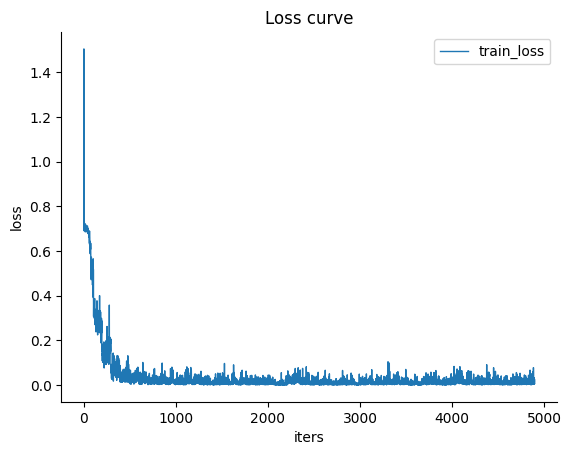

test model


100%|██████████| 391/391 [00:06<00:00, 62.82it/s]


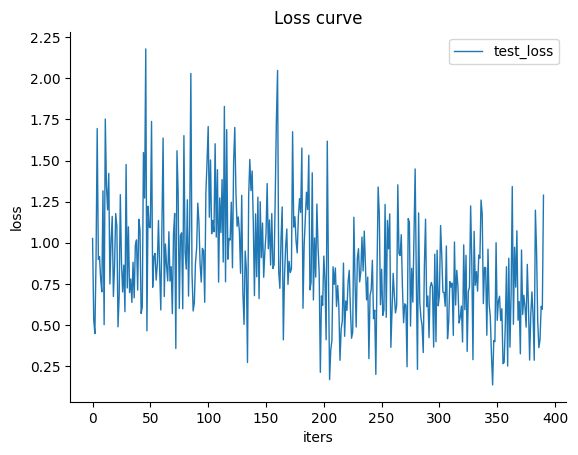

Accuracy of all: 85.276 %
Accuracy of pos: 86.69995838535164 %
Accuracy of neg: 83.95841355410089 %
333.41875


In [165]:
# 主函数

def main():

    # 加载云端硬盘
    from google.colab import drive
    drive.mount('/content/drive')

    train_dir = '/content/drive/MyDrive/Colab Notebooks/aclImdb_v1/aclImdb/train'  # 原训练集文件地址
    train_path = '/content/drive/MyDrive/Colab Notebooks/train.txt'  # 预处理后的训练集文件地址

    test_dir = '/content/drive/MyDrive/Colab Notebooks/aclImdb_v1/aclImdb/test'  # 原训练集文件地址
    test_path = '/content/drive/MyDrive/Colab Notebooks/test.txt'  # 预处理后的训练集文件地址

    vocab = data_process(train_path, train_dir) # 数据预处理
    data_process(test_path, test_dir)

    # 词典保存为本地
    np.save('vocab.npy', vocab)
    # 加载本地已经存储的vocab
    vocab = np.load('vocab.npy', allow_pickle=True).item()

    # 构建MyDataset实例
    train_data = MyDataset(text_path=train_path)
    test_data = MyDataset(text_path=test_path)

    # 构建DataLoder
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

    # 生成模型
    # model = LSTM(vocab=vocab, input_size=300, hidden_size=128, num_layers=2)  # 定义LSTM模型
    model = GRU(vocab=vocab, input_size=300, hidden_size=128, num_layers=2)  # 定义GRU模型

    train(model=model, train_data=train_loader, vocab=vocab, epoch=50)

    # 加载训练好的模型
    model.load_state_dict(torch.load('IMDB_parameter.pkl', map_location=torch.device('cpu')))

    # 测试结果
    acc = test(model=model, test_data=test_loader, vocab=vocab)
    print(acc)

if __name__ == '__main__':
    main()

